In [1]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.decomposition import PCA

os.makedirs("artifacts/figures", exist_ok=True)
os.makedirs("artifacts/labels", exist_ok=True)


In [2]:
def build_preprocess(X: pd.DataFrame):
    num_cols = X.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])

    if len(cat_cols) == 0:
        return ColumnTransformer([("num", num_pipe, num_cols)])

    return ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ])

def metrics_internal(Xm, labels):
    labels = np.asarray(labels)
    noise_share = float((labels == -1).mean())

    mask = labels != -1
    if mask.sum() < 2 or len(np.unique(labels[mask])) < 2:
        return {"silhouette": None, "davies_bouldin": None, "calinski_harabasz": None, "noise_share": noise_share}

    Xm2 = Xm[mask]
    y2 = labels[mask]
    return {
        "silhouette": float(silhouette_score(Xm2, y2)),            # выше лучше [web:95]
        "davies_bouldin": float(davies_bouldin_score(Xm2, y2)),    # ниже лучше [web:97]
        "calinski_harabasz": float(calinski_harabasz_score(Xm2, y2)), # выше лучше [web:97]
        "noise_share": noise_share,
    }

def pca_2d(Xm):
    # Xm может быть sparse
    if hasattr(Xm, "toarray"):
        Xm = Xm.toarray()
    return PCA(n_components=2, random_state=42).fit_transform(Xm)


In [6]:
def run_dataset(ds_name, csv_path, second_algo="dbscan"):
    df = pd.read_csv(csv_path)
    sample_id = df["sample_id"]
    X = df.drop(columns=["sample_id"])

    print(ds_name, "shape:", df.shape)
    print(df.isna().mean().sort_values(ascending=False).head(10))

    preprocess = build_preprocess(X)
    Xm = preprocess.fit_transform(X)

    # --- KMeans подбор k ---
    ks = range(2, 21)
    sils = []
    km_labels_by_k = {}
    for k in ks:
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")  # фиксируем random_state [web:96]
        labels = km.fit_predict(Xm)
        km_labels_by_k[k] = labels
        sils.append(silhouette_score(Xm, labels))

    best_k = int(ks[int(np.argmax(sils))])
    plt.plot(list(ks), sils)
    plt.xlabel("k"); plt.ylabel("silhouette"); plt.grid(True)
    plt.savefig(f"artifacts/figures/{ds_name}_kmeans_silhouette_vs_k.png", dpi=150, bbox_inches="tight")
    plt.show()

    candidates = []
    candidates.append(("kmeans", {"k": best_k}, km_labels_by_k[best_k], metrics_internal(Xm, km_labels_by_k[best_k])))

    # --- Второй алгоритм ---
    if second_algo == "dbscan":
        eps_grid = np.linspace(0.5, 5.0, 10)
        best = None
        best_score = -1
        curve = []

        for eps in eps_grid:
            db = DBSCAN(eps=float(eps), min_samples=5)
            labels = db.fit_predict(Xm)

            m = metrics_internal(Xm, labels)

            score = m["silhouette"]
            score_num = score if score is not None else -1
            curve.append(score_num)

            if score_num > best_score:
                best_score = score_num
                best = ("dbscan", {"eps": float(eps), "min_samples": 5}, labels, m)

        plt.plot(eps_grid, curve)
        plt.xlabel("eps"); plt.ylabel("silhouette (no-noise)"); plt.grid(True)
        plt.savefig(f"artifacts/figures/{ds_name}_dbscan_silhouette_vs_eps.png", dpi=150, bbox_inches="tight")
        plt.show()

        candidates.append(best)

    if second_algo == "agglo":
        # пробуем 2 linkage
        for linkage in ["ward", "average"]:
            for k in [best_k, best_k+1, best_k+2]:
                ag = AgglomerativeClustering(n_clusters=k, linkage=linkage)  # linkage [web:101]
                labels = ag.fit_predict(Xm)
                candidates.append(("agglo", {"k": k, "linkage": linkage}, labels, metrics_internal(Xm, labels)))

    # --- выбор лучшего (по silhouette) ---
    best_method, best_cfg, best_labels, best_m = max(
        candidates, key=lambda x: -1 if x[3]["silhouette"] is None else x[3]["silhouette"]
    )

    # --- PCA scatter ---
    X2 = pca_2d(Xm)
    plt.figure(figsize=(6,5))
    plt.scatter(X2[:,0], X2[:,1], c=best_labels, s=8, cmap="tab10")
    plt.title(f"{ds_name}: PCA(2D), best={best_method}")
    plt.savefig(f"artifacts/figures/{ds_name}_pca_best.png", dpi=150, bbox_inches="tight")
    plt.show()

    # --- labels CSV ---
    pd.DataFrame({"sample_id": sample_id, "cluster_label": best_labels}).to_csv(
        f"artifacts/labels/labels_{ds_name}.csv", index=False
    )

    return {
        "dataset": ds_name,
        "best_method": best_method,
        "best_config": best_cfg,
        "metrics": best_m,
    }


ds02 shape: (8000, 4)
sample_id    0.0
x1           0.0
x2           0.0
z_noise      0.0
dtype: float64


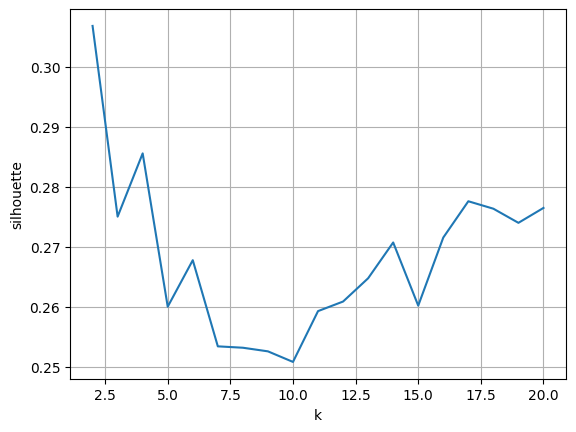

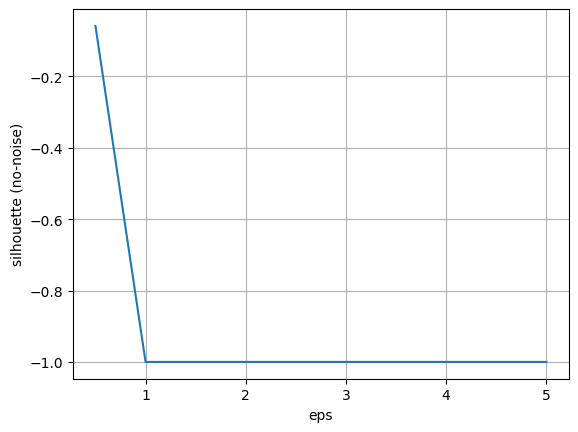

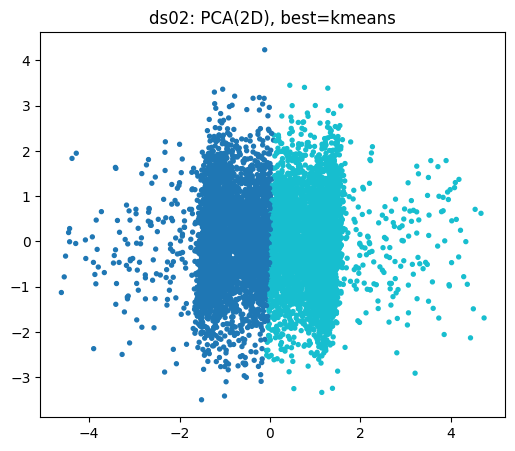

ds03 shape: (15000, 5)
sample_id    0.0
x1           0.0
x2           0.0
f_corr       0.0
f_noise      0.0
dtype: float64


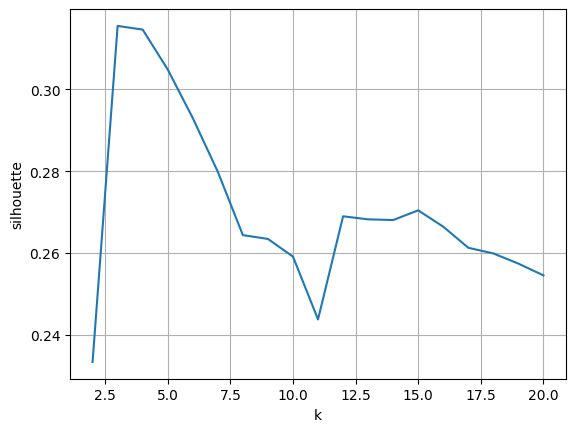

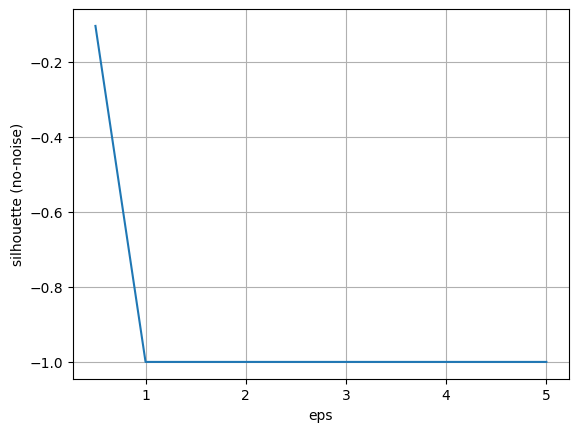

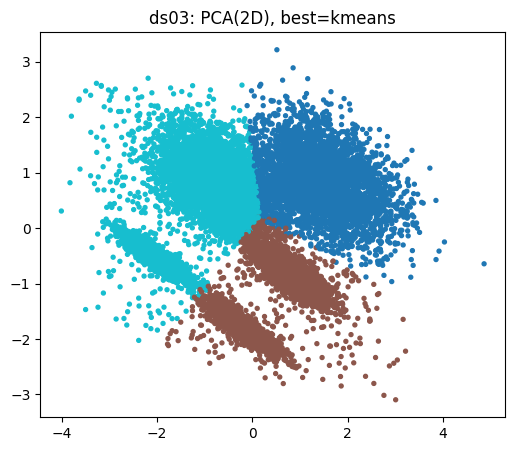

ds04 shape: (10000, 33)
n26    0.0224
n21    0.0215
n18    0.0212
n17    0.0212
n28    0.0211
n24    0.0207
n07    0.0204
n11    0.0204
n20    0.0203
n29    0.0202
dtype: float64


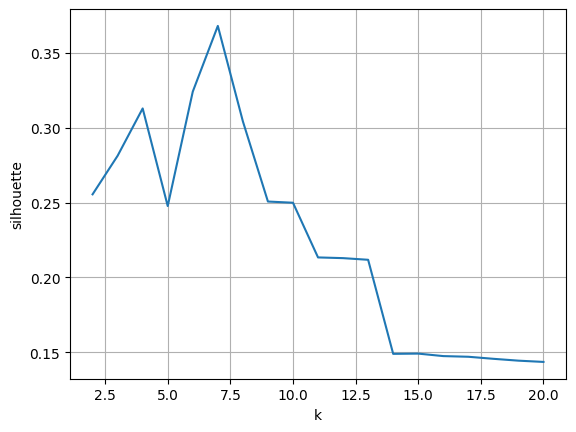

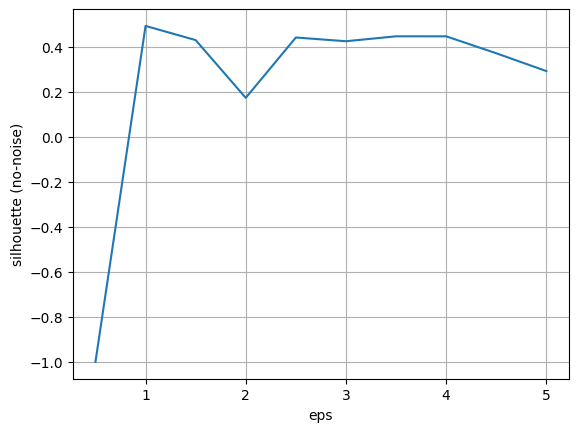

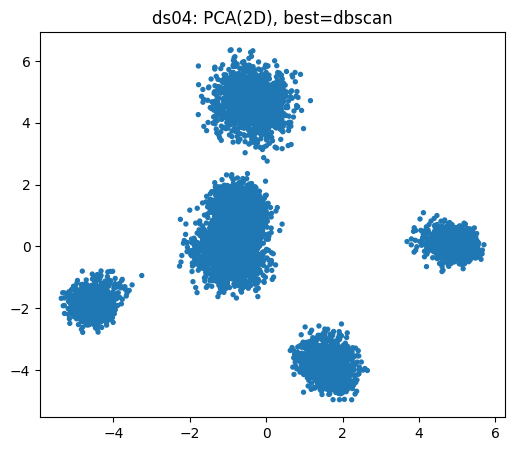

In [7]:
summary = []
summary.append(run_dataset("ds02", "data/S07-hw-dataset-02.csv", second_algo="dbscan"))
summary.append(run_dataset("ds03", "data/S07-hw-dataset-03.csv", second_algo="dbscan"))
summary.append(run_dataset("ds04", "data/S07-hw-dataset-04.csv", second_algo="dbscan"))

with open("artifacts/metrics_summary.json", "w") as f:
    json.dump({s["dataset"]: s["metrics"] for s in summary}, f, indent=2)
with open("artifacts/best_configs.json", "w") as f:
    json.dump({s["dataset"]: {"method": s["best_method"], "config": s["best_config"]} for s in summary}, f, indent=2)


In [8]:
# stability check (пример для ds02 и выбранного k)
df = pd.read_csv("data/S07-hw-dataset-02.csv")
X = df.drop(columns=["sample_id"])
Xm = build_preprocess(X).fit_transform(X)

k = 5  # поставь best_k для ds02
seeds = [0, 1, 2, 3, 4]
labels_list = []
for s in seeds:
    km = KMeans(n_clusters=k, random_state=s, n_init="auto")
    labels_list.append(km.fit_predict(Xm))

aris = []
for i in range(len(labels_list)-1):
    aris.append(adjusted_rand_score(labels_list[0], labels_list[i+1]))
print("ARI vs seed0:", aris)


ARI vs seed0: [0.7118333767139874, 0.7665287512467792, 0.8927345519567219, 0.9611459500384766]
